# Introduction****

This Kaggle notebook implements a comprehensive fraud detection system for e-commerce transactions. The system incorporates advanced feature engineering, class imbalance handling, base model training, a neural network model, and an ensemble approach to improve prediction accuracy. The notebook is structured for seamless execution in a Kaggle environment with GPU acceleration.

# 1: Environment Setup****

Key Points:
* Libraries Imported: Necessary libraries like pandas, numpy, matplotlib, and scikit-learn for data manipulation, visualization, and machine learning are imported. Advanced tools like imblearn (for handling imbalanced data) and xgboost are also included.
  
* GPU Utilization: Checks for GPU availability and configures TensorFlow to optimize memory usage for deep learning tasks. This ensures efficient execution on Kaggle's T4x2 GPU.

  
* Suppressing Warnings: TensorFlow and other logging messages are suppressed to provide a clean output in the notebook.


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Input
from imblearn.over_sampling import SMOTE
import gc
import tensorflow as tf
import absl.logging
from datetime import datetime
from scipy import stats

# Suppress warnings and set environment variables
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
absl.logging.set_verbosity(absl.logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

# Ensure TensorFlow uses GPU if available
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("GPU available: ", physical_devices)
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
    except Exception as e:
        print(f"Error setting memory growth: {e}")
else:
    print("No GPU available, using CPU.")

No GPU available, using CPU.


# 2: Data Loading and Preprocessing****
Key Points:
* Data Loading: A helper function loads the dataset while handling errors gracefully.
* Preprocessing:
    * Numeric Features: Missing values are replaced with the median.* 
    * Categorical Features: Missing values are replaced with "Unknown."
    * Feature Engineering:
      * Transaction-based features: Amount_Log, Amount_per_Quantity, and Amount_zscore for       transaction patterns.
      * Time-based features: Binning hours into categories, detecting weekends, and extracting the day of the week.
      * Customer profile: Categorizing customer age, calculating account age in weeks, and identifying new accounts.
      * Transaction patterns: Segmenting transaction sizes into quantiles and adding log-transformed quantity.
      * Risk indicators: Flags for high transaction amounts, large quantities, and unusual hours.
    * Interaction terms: Combined location and device type for enhanced modeling.
  * Encoding: Encodes categorical features using LabelEncoder for compatibility with machine learning algorithms.


In [2]:
# Load data
def load_data(file_path,sampling= True):
    try:
        df = pd.read_csv(file_path)
        print(f"Data loaded successfully from {file_path}")
        if sampling:
            df = df.sample(frac=0.1, random_state=42).reset_index(drop=True)
            print("Data sampled to 10% for faster processing.")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def preprocess_data(df, is_training=True, label_encoders=None):
    df = df.copy()
    
    # Original features
    numeric_cols = ['Transaction Amount', 'Quantity', 'Customer Age', 'Account Age Days', 'Transaction Hour']
    categorical_cols = ['Payment Method', 'Product Category', 'Customer Location', 'Device Used']
    
    # Handle missing values
    for col in numeric_cols:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].median())

    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].fillna('Unknown')

    # Advanced Feature Engineering
    
    # 1. Transaction Amount Features
    df['Amount_Log'] = np.log1p(df['Transaction Amount'])
    df['Amount_per_Quantity'] = df['Transaction Amount'] / (df['Quantity'] + 1)
    df['Amount_zscore'] = stats.zscore(df['Transaction Amount'], nan_policy='omit')
    
    # 2. Time-based Features
    df['Hour_Bin'] = pd.cut(df['Transaction Hour'], bins=[-np.inf, 6, 12, 18, np.inf], labels=['Night', 'Morning', 'Afternoon', 'Evening'])
    df['Is_Weekend'] = (pd.to_datetime(df['Transaction Date']).dt.dayofweek >= 5).astype(int)
    df['Day_of_Week'] = pd.to_datetime(df['Transaction Date']).dt.dayofweek
    
    # 3. Customer Profile Features
    df['Age_Category'] = pd.cut(df['Customer Age'], bins=[0, 25, 35, 50, 65, np.inf], labels=['Young', 'Young_Adult', 'Adult', 'Senior', 'Elder'])
    df['Account_Age_Weeks'] = df['Account Age Days'] // 7
    df['Is_New_Account'] = (df['Account Age Days'] <= 30).astype(int)
    
    # 4. Transaction Pattern Features
    df['Transaction_Size'] = pd.qcut(df['Transaction Amount'], q=5, labels=['Very_Small', 'Small', 'Medium', 'Large', 'Very_Large'], duplicates='drop')
    df['Quantity_Log'] = np.log1p(df['Quantity'])
    
    # 5. Location-Device Interaction
    df['Location_Device'] = df['Customer Location'] + '_' + df['Device Used']
    
    # 6. Risk Indicators
    df['High_Amount_Flag'] = (df['Transaction Amount'] > df['Transaction Amount'].quantile(0.95)).astype(int)
    df['High_Quantity_Flag'] = (df['Quantity'] > df['Quantity'].quantile(0.95)).astype(int)
    df['Unusual_Hour_Flag'] = ((df['Transaction Hour'] < 6) | (df['Transaction Hour'] > 22)).astype(int)
    
    # Handle categorical encoding
    if is_training:
        label_encoders = {}
        for col in categorical_cols + ['Hour_Bin', 'Age_Category', 'Transaction_Size', 'Location_Device']:
            if col in df.columns:
                label_encoders[col] = LabelEncoder()
                df[col] = label_encoders[col].fit_transform(df[col])
        return df, label_encoders
    else:
        for col in categorical_cols + ['Hour_Bin', 'Age_Category', 'Transaction_Size', 'Location_Device']:
            if col in df.columns and col in label_encoders:
                df[col] = df[col].map(lambda x: 'Unknown' if x not in label_encoders[col].classes_ else x)
                if 'Unknown' not in label_encoders[col].classes_:
                    label_encoders[col].classes_ = np.append(label_encoders[col].classes_, 'Unknown')
                df[col] = label_encoders[col].transform(df[col])
        return df


# 3: Handling Class Imbalance****
Key Points:
* SMOTE (Synthetic Minority Oversampling Technique): Balances the dataset by generating synthetic samples for the minority (fraudulent) class.
* Impact: Ensures that machine learning models are not biased toward the majority (legitimate) class, improving fraud detection performance.

In [3]:
# Handle imbalance
def handle_imbalance(X, y):
    print("Class distribution before SMOTE:")
    print(y.value_counts())
    
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    print("\nClass distribution after SMOTE:")
    print(y_resampled.value_counts())
    
    return X_resampled, y_resampled

# Part 4: Base Model Trainer****
Key Points:

* Base Models: Implements three widely used machine learning algorithms:
1. Logistic Regression: A simple yet effective baseline model for binary classification.
2. Random Forest: A robust ensemble learning method that uses multiple decision trees.
3. XGBoost: An advanced gradient boosting model for high performance.
* Training: Models are trained on the resampled dataset using their default or tuned hyperparameters.
* Evaluation Metrics: Calculates key metrics like accuracy, precision, recall, F1-score, ROC AUC, and confusion matrices for each model.

In [4]:
# Base Model Trainer
class BaseModelTrainer:
    def __init__(self):
        self.models = {
            'Logistic Regression': LogisticRegression(max_iter=1000, solver='liblinear'),
            'Random Forest': RandomForestClassifier(n_estimators=500, max_depth=30, n_jobs=-1),
            'XGBoost': xgb.XGBClassifier(n_estimators=1000, max_depth=15, learning_rate=0.01, tree_method='hist', use_label_encoder=False)
        }
        self.best_models = {}

    def train(self, X_train, y_train):
        for model_name, model in self.models.items():
            model.fit(X_train, y_train)
            self.best_models[model_name] = model
            gc.collect()

    def evaluate(self, X_val, y_val):
        results = {}
        for model_name, model in self.best_models.items():
            y_pred = model.predict(X_val)
            y_prob = model.predict_proba(X_val)[:, 1]
            fpr, tpr, _ = roc_curve(y_val, y_prob)
            roc_auc = auc(fpr, tpr)
            accuracy = accuracy_score(y_val, y_pred)
            precision = precision_score(y_val, y_pred)
            recall = recall_score(y_val, y_pred)
            f1 = f1_score(y_val, y_pred)
            confusion = confusion_matrix(y_val, y_pred)
            results[model_name] = {
                'ROC AUC': roc_auc,
                'Accuracy': accuracy,
                'F1 Score': f1,
                'Precision': precision,
                'Recall': recall,
                'y_prob': y_prob,
                'Confusion Matrix': confusion
            }
        return results

# 5: Neural Network Model****
Key Points:
* Deep Learning Model:
1. Architecture: A feedforward neural network with multiple dense layers, batch normalization, and dropout to prevent overfitting.
2. Activation Functions: Relu for hidden layers and sigmoid for the output layer to predict probabilities.
3. Compilation: Optimized with the Adam optimizer and binary crossentropy loss.
* Training: Implements early stopping to prevent overfitting during training.
* Evaluation: Calculates the same metrics as base models to ensure comparability.

In [5]:
# Neural Network Model
class NeuralNetworkModel:
    def __init__(self, input_dim):
        self.model = Sequential([
            Input(shape=(input_dim,)),
            Dense(1024, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(256, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

    def train(self, X_train, y_train, X_val, y_val):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        self.model.fit(X_train, y_train, epochs=200, batch_size=256, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)

    def evaluate(self, X_val, y_val):
        y_prob = self.model.predict(X_val).flatten()
        y_pred = (y_prob > 0.5).astype(int)
        fpr, tpr, _ = roc_curve(y_val, y_prob)
        roc_auc = auc(fpr, tpr)
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        confusion = confusion_matrix(y_val, y_pred)
        return {
            'ROC AUC': roc_auc,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Precision': precision,
            'Recall': recall,
            'y_prob': y_prob,
            'Confusion Matrix': confusion
        }

# 6: Ensemble Model****
Key Points:
* Ensemble Strategy: Combines predictions from base models (Logistic Regression, Random Forest, XGBoost) and the Neural Network using a meta-model (Logistic Regression).
* Meta-Learning: Trains the meta-model to find optimal weights for combining the predictions of individual models.
* Final Predictions: Produces weighted predictions from all models to maximize accuracy and robustness.

In [6]:
# Ensemble Model
class EnsembleModel:
    def __init__(self, base_models, nn_model):
        self.base_models = base_models
        self.nn_model = nn_model
        self.weights = None

    def train(self, X_val, y_val):
        base_preds = np.column_stack([model.predict_proba(X_val)[:, 1] for model in self.base_models.values()])
        nn_preds = self.nn_model.model.predict(X_val).flatten()
        all_preds = np.column_stack([base_preds, nn_preds])

        # Use logistic regression to find optimal weights
        meta_model = LogisticRegression()
        meta_model.fit(all_preds, y_val)
        self.weights = meta_model.coef_[0] / np.sum(meta_model.coef_[0])

    def predict(self, X_val):
        base_preds = np.column_stack([model.predict_proba(X_val)[:, 1] for model in self.base_models.values()])
        nn_preds = self.nn_model.model.predict(X_val).flatten()
        all_preds = np.column_stack([base_preds, nn_preds])
        return np.dot(all_preds, self.weights)

    def evaluate(self, X_val, y_val):
        y_prob = self.predict(X_val)
        y_pred = (y_prob > 0.5).astype(int)
        fpr, tpr, _ = roc_curve(y_val, y_prob)
        roc_auc = auc(fpr, tpr)
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        confusion = confusion_matrix(y_val, y_pred)
        return {
            'ROC AUC': roc_auc,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Precision': precision,
            'Recall': recall,
            'y_prob': y_prob,
            'Confusion Matrix': confusion
        }

# 7: Visualization****
Key Points:
* ROC-AUC Curves: Plots the Receiver Operating Characteristic (ROC) curve for each model, including the ensemble model, to compare their performance visually.
* Model Comparisons: Highlights the advantages of the ensemble model over individual base models and the neural network.

In [7]:
# Visualization function1
def plot_auc_roc_curve(models_results, nn_results, ensemble_results, y_val):
    plt.figure(figsize=(12, 8))

    for model_name, metrics in models_results.items():
        fpr, tpr, _ = roc_curve(y_val, metrics['y_prob'])
        plt.plot(fpr, tpr, label=f'{model_name} (AUC: {metrics["ROC AUC"]:.4f})')

    fpr, tpr, _ = roc_curve(y_val, nn_results['y_prob'])
    plt.plot(fpr, tpr, label=f'Neural Network (AUC: {nn_results["ROC AUC"]:.4f})', linestyle='-.')

    fpr, tpr, _ = roc_curve(y_val, ensemble_results['y_prob'])
    plt.plot(fpr, tpr, label=f'Ensemble Model (AUC: {ensemble_results["ROC AUC"]:.4f})', linestyle='--')

    plt.title('ROC Curve Comparison')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

In [8]:
# Visualization function2
def plot_metrics(models_results, nn_results, ensemble_results):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 16))

    # Accuracy
    ax1.bar(['Logistic Regression', 'Random Forest', 'XGBoost', 'Neural Network', 'Ensemble'],
           [models_results['Logistic Regression']['Accuracy'],
            models_results['Random Forest']['Accuracy'],
            models_results['XGBoost']['Accuracy'],
            nn_results['Accuracy'],
            ensemble_results['Accuracy']])
    ax1.set_title('Accuracy')

    # F1 Score
    ax2.bar(['Logistic Regression', 'Random Forest', 'XGBoost', 'Neural Network', 'Ensemble'],
           [models_results['Logistic Regression']['F1 Score'],
            models_results['Random Forest']['F1 Score'],
            models_results['XGBoost']['F1 Score'],
            nn_results['F1 Score'],
            ensemble_results['F1 Score']])
    ax2.set_title('F1 Score')

    # Precision
    ax3.bar(['Logistic Regression', 'Random Forest', 'XGBoost', 'Neural Network', 'Ensemble'],
           [models_results['Logistic Regression']['Precision'],
            models_results['Random Forest']['Precision'],
            models_results['XGBoost']['Precision'],
            nn_results['Precision'],
            ensemble_results['Precision']])
    ax3.set_title('Precision')

    # Recall
    ax4.bar(['Logistic Regression', 'Random Forest', 'XGBoost', 'Neural Network', 'Ensemble'],
           [models_results['Logistic Regression']['Recall'],
            models_results['Random Forest']['Recall'],
            models_results['XGBoost']['Recall'],
            nn_results['Recall'],
            ensemble_results['Recall']])
    ax4.set_title('Recall')

    plt.tight_layout()
    plt.show()

# Plot confusion matrices
def plot_confusion_matrices(models_results, nn_results, ensemble_results):
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    models_list = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Neural Network', 'Ensemble']
    results_list = [models_results, models_results, models_results, nn_results, ensemble_results]

    for i, (model_name, results) in enumerate(zip(models_list, results_list)):
        ax = axes[i // 3, i % 3]
        confusion = results[model_name]['Confusion Matrix'] if model_name in results else results['Confusion Matrix']
        im = ax.imshow(confusion, cmap='Blues')
        ax.set_title(f'Confusion Matrix - {model_name}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')

        # Annotate the confusion matrix
        for x in range(confusion.shape[0]):
            for y in range(confusion.shape[1]):
                ax.text(y, x, f'{confusion[x, y]}', ha='center', va='center', color='black')

        fig.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.show()


# Pipeline Overview****

The run_pipeline function serves as the backbone of the fraud detection system, integrating multiple tasks into a streamlined workflow. The pipeline is designed to:

1. Preprocess raw data.
2. Engineer advanced features.
3. Address class imbalance using synthetic techniques.
4. Train and evaluate individual models (base models and neural networks).
5. Combine the predictions of multiple models into an ensemble.
6. Evaluate and visualize the results to identify the most important features and the best-performing model.

Data loaded successfully from ./fraud_dataset/Fraudulent_E-Commerce_Transaction_Data.csv
Data sampled to 10% for faster processing.
Data loaded successfully from ./fraud_dataset/Fraudulent_E-Commerce_Transaction_Data_2.csv
Class distribution before SMOTE:
Is Fraudulent
0    139909
1      7386
Name: count, dtype: int64

Class distribution after SMOTE:
Is Fraudulent
0    139909
1    139909
Name: count, dtype: int64


d:\python\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:36:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


1749/1749 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


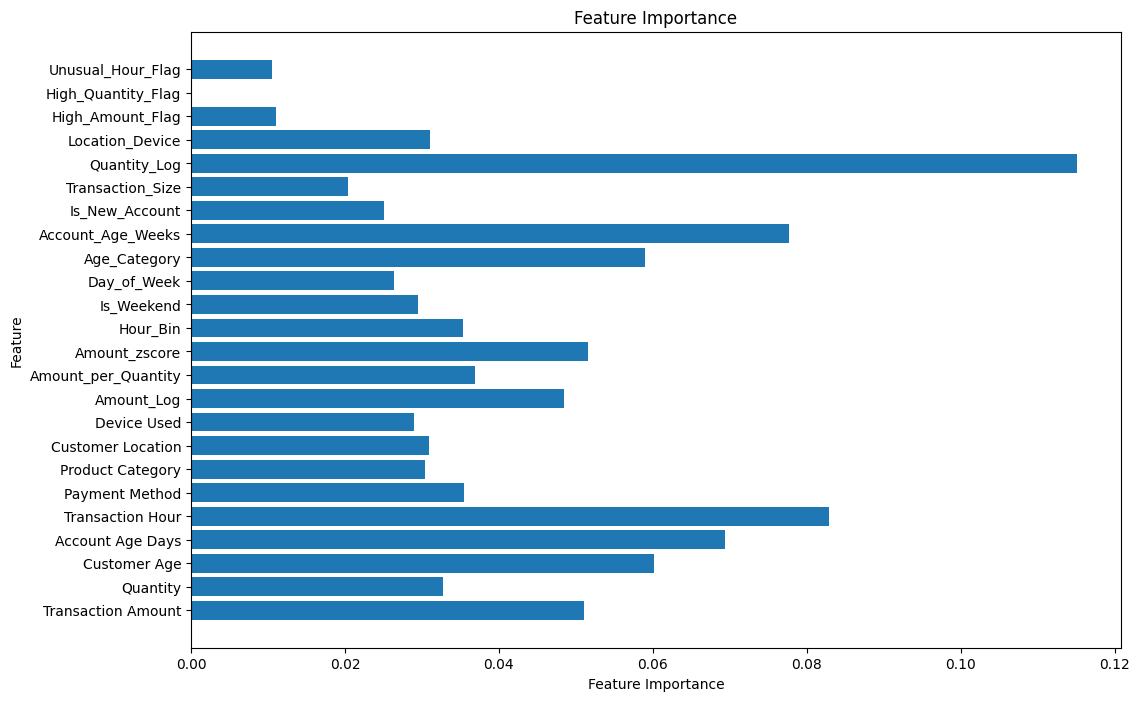


Base Model Results:
Logistic Regression:
  - ROC AUC: 0.9451
  - Accuracy: 0.8766
  - F1 Score: 0.8748
  - Precision: 0.8872
  - Recall: 0.8628
  - Confusion Matrix:
[[24913  3069]
 [ 3839 24143]]

Random Forest:
  - ROC AUC: 0.9912
  - Accuracy: 0.9650
  - F1 Score: 0.9647
  - Precision: 0.9727
  - Recall: 0.9568
  - Confusion Matrix:
[[27231   751]
 [ 1208 26774]]

XGBoost:
  - ROC AUC: 0.9910
  - Accuracy: 0.9692
  - F1 Score: 0.9686
  - Precision: 0.9888
  - Recall: 0.9491
  - Confusion Matrix:
[[27681   301]
 [ 1423 26559]]


Neural Network Results:
  - ROC AUC: 0.9877
  - Accuracy: 0.9607
  - F1 Score: 0.9595
  - Precision: 0.9891
  - Recall: 0.9316
  - Confusion Matrix:
[[27695   287]
 [ 1913 26069]]


Ensemble Model Results:
  - ROC AUC: 0.9925
  - Accuracy: 0.9704
  - F1 Score: 0.9698
  - Precision: 0.9869
  - Recall: 0.9533
  - Confusion Matrix:
[[27629   353]
 [ 1306 26676]]



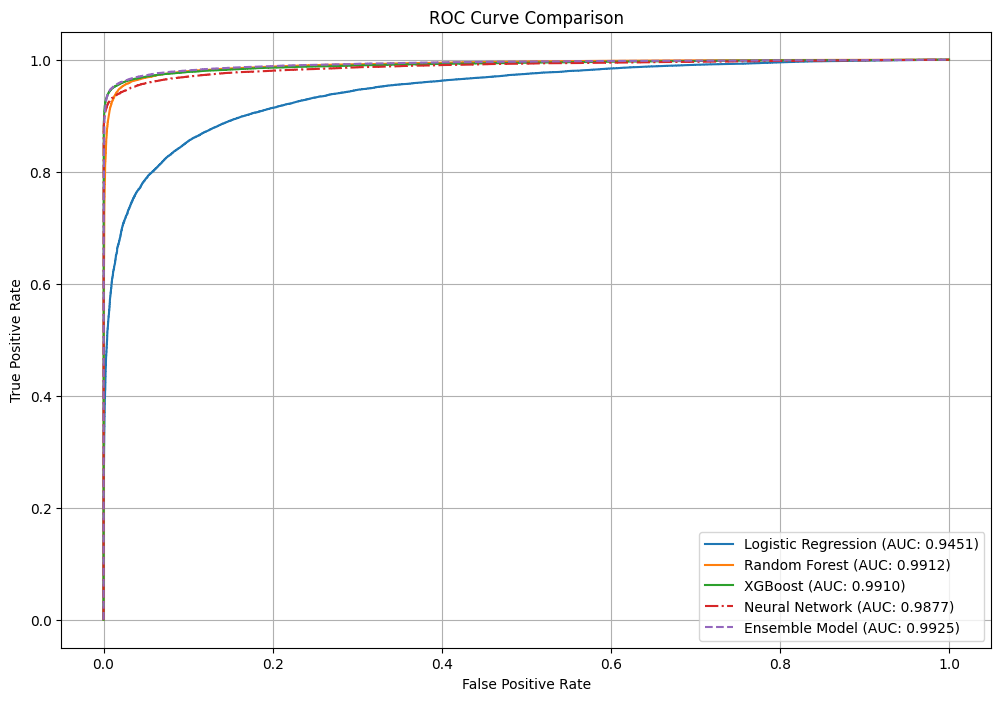

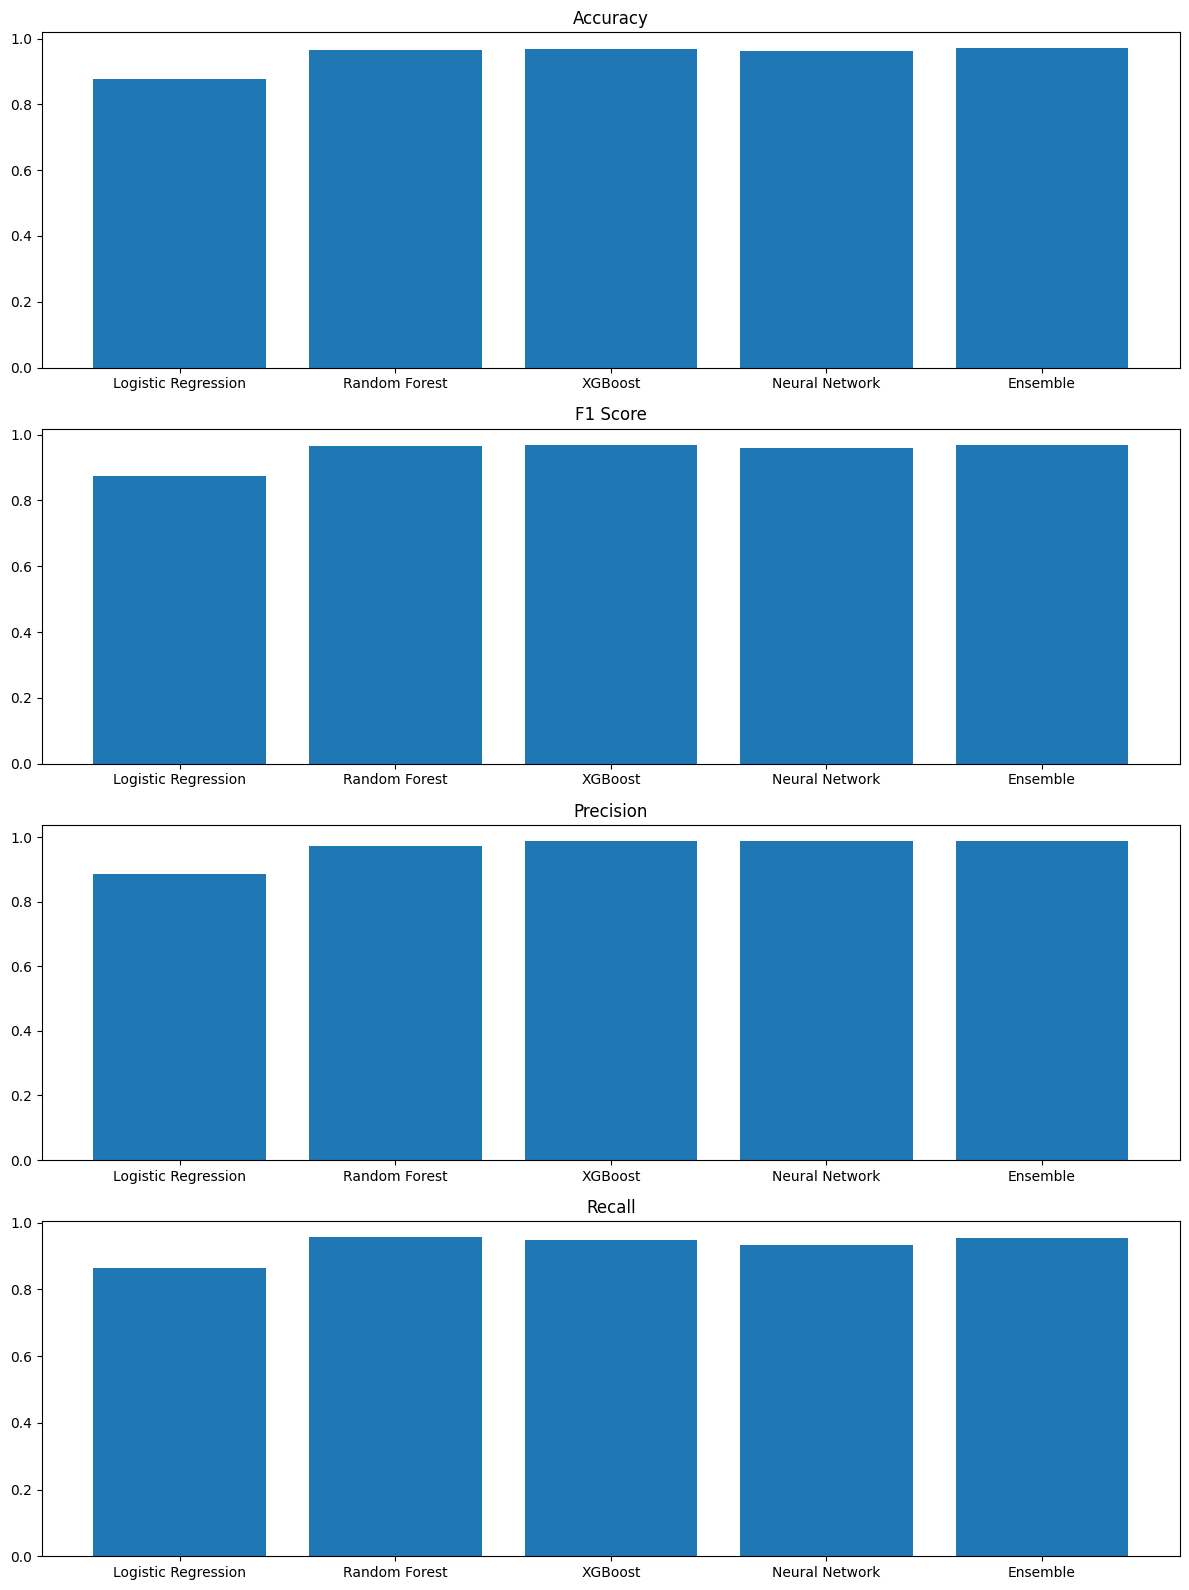

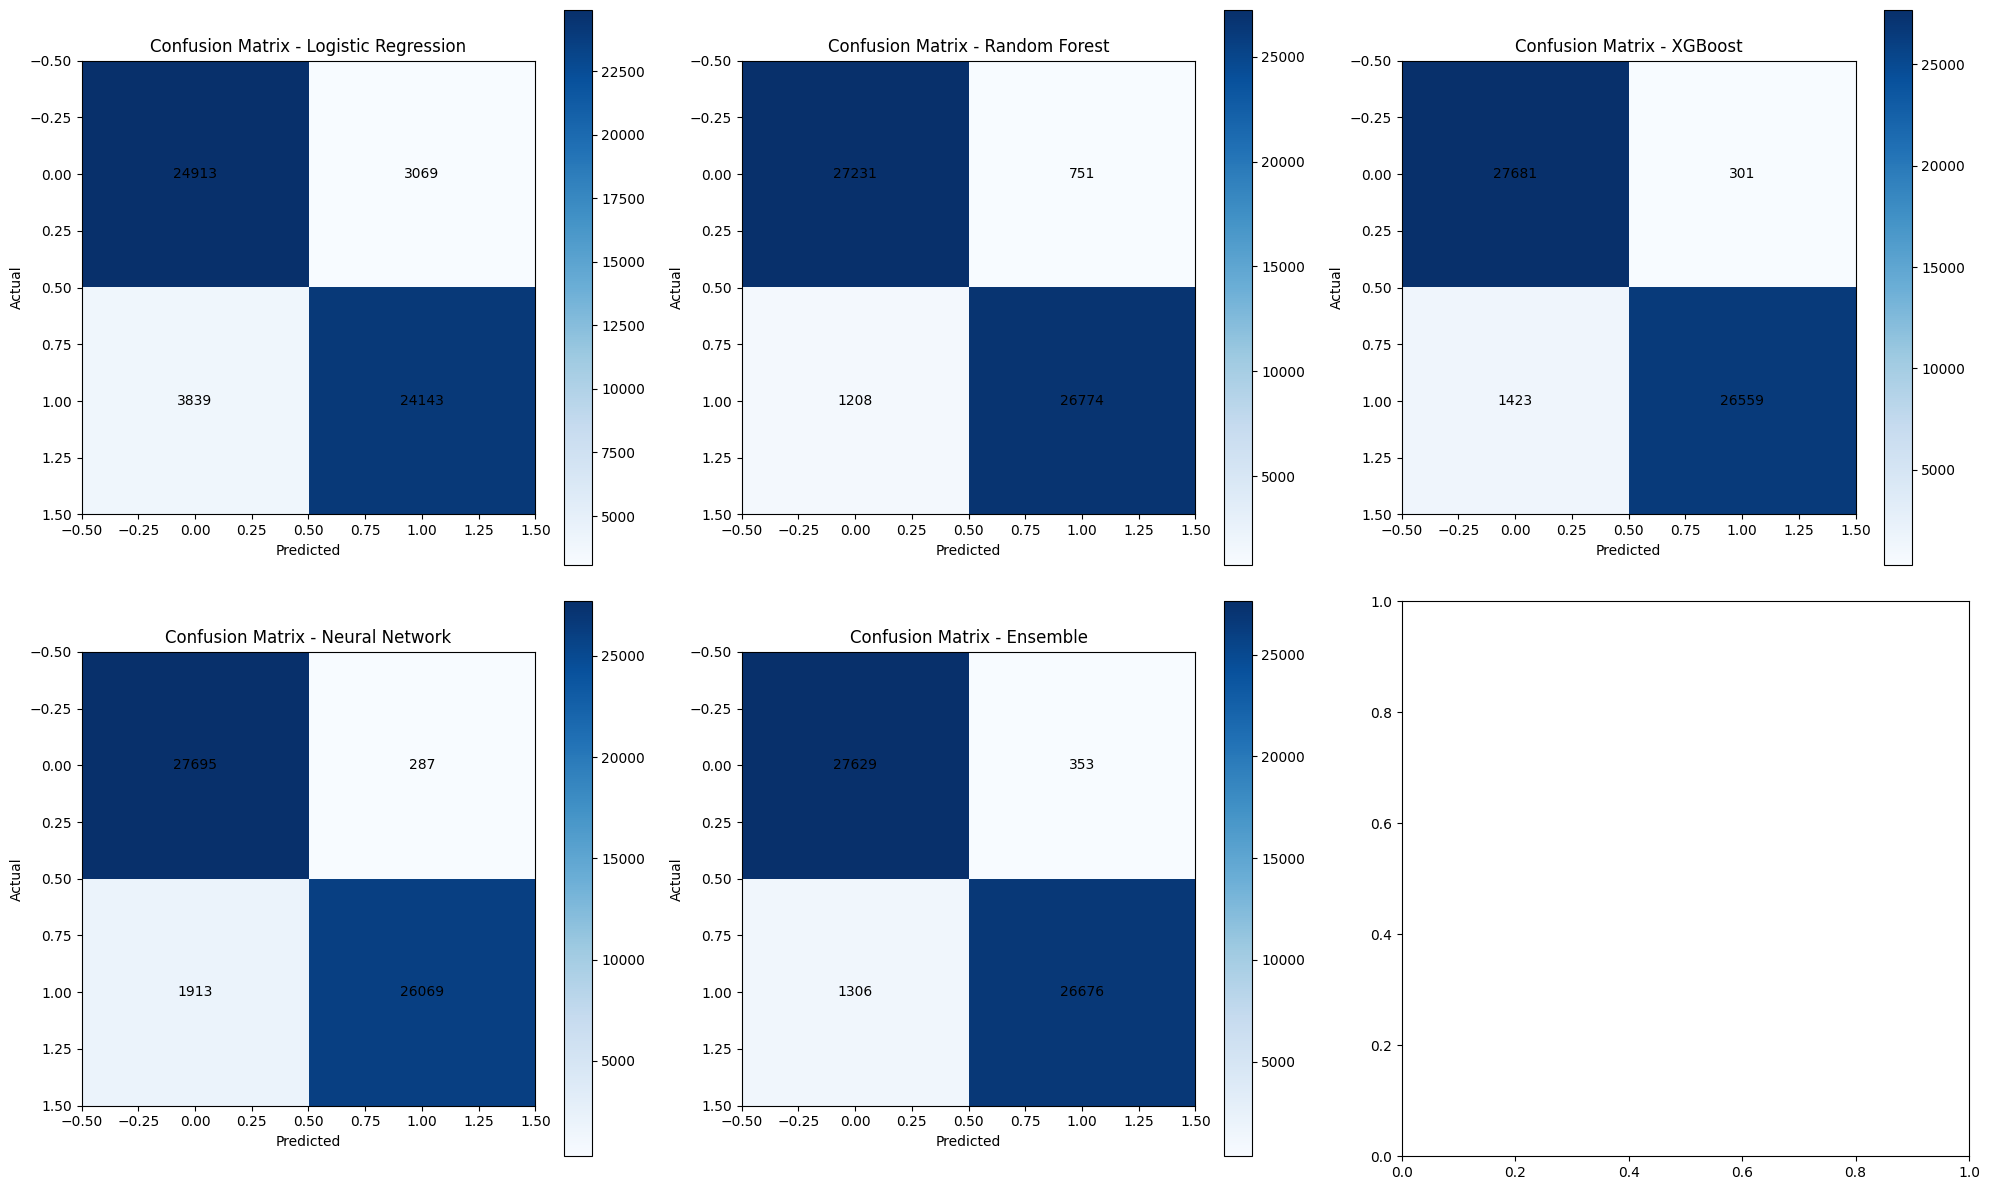

In [9]:
# Run Pipeline
def run_pipeline(train_df, test_df):
    # Preprocess data
    train_df, label_encoders = preprocess_data(train_df, is_training=True)
    test_df = preprocess_data(test_df, is_training=False, label_encoders=label_encoders)

    # Define feature columns and target including new engineered features
    features = [
        # Original features
        'Transaction Amount', 'Quantity', 'Customer Age', 'Account Age Days', 'Transaction Hour',
        'Payment Method', 'Product Category', 'Customer Location', 'Device Used',
        # Amount-based features
        'Amount_Log', 'Amount_per_Quantity', 'Amount_zscore',
        # Time-based features
        'Hour_Bin', 'Is_Weekend', 'Day_of_Week',
        # Customer profile features
        'Age_Category', 'Account_Age_Weeks', 'Is_New_Account',
        # Transaction pattern features
        'Transaction_Size', 'Quantity_Log',
        # Location-Device interaction
        'Location_Device',
        # Risk indicators
        'High_Amount_Flag', 'High_Quantity_Flag', 'Unusual_Hour_Flag'
    ]

    X = train_df[features]
    y = train_df['Is Fraudulent']

    # Handle class imbalance
    X_resampled, y_resampled = handle_imbalance(X, y)

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Train base models
    base_trainer = BaseModelTrainer()
    base_trainer.train(X_train_scaled, y_train)

    # Evaluate base models
    base_results = base_trainer.evaluate(X_val_scaled, y_val)

    # Train neural network model
    input_dim = X_train_scaled.shape[1]
    nn_model = NeuralNetworkModel(input_dim=input_dim)
    nn_model.train(X_train_scaled, y_train, X_val_scaled, y_val)

    # Evaluate neural network model
    nn_results = nn_model.evaluate(X_val_scaled, y_val)

    # Train and evaluate ensemble model
    ensemble_model = EnsembleModel(base_models=base_trainer.best_models, nn_model=nn_model)
    ensemble_model.train(X_val_scaled, y_val)
    ensemble_results = ensemble_model.evaluate(X_val_scaled, y_val)

    # Calculate feature importance
    rf_model = RandomForestClassifier(n_estimators=500, max_depth=30, n_jobs=-1)
    rf_model.fit(X_train_scaled, y_train)
    feature_importances = rf_model.feature_importances_

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(features, feature_importances)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.show()

    # Print results
    print("\nBase Model Results:")
    for model_name, metrics in base_results.items():
        print(f"{model_name}:")
        print(f"  - ROC AUC: {metrics['ROC AUC']:.4f}")
        print(f"  - Accuracy: {metrics['Accuracy']:.4f}")
        print(f"  - F1 Score: {metrics['F1 Score']:.4f}")
        print(f"  - Precision: {metrics['Precision']:.4f}")
        print(f"  - Recall: {metrics['Recall']:.4f}")
        print(f"  - Confusion Matrix:\n{metrics['Confusion Matrix']}\n")

    print("\nNeural Network Results:")
    print(f"  - ROC AUC: {nn_results['ROC AUC']:.4f}")
    print(f"  - Accuracy: {nn_results['Accuracy']:.4f}")
    print(f"  - F1 Score: {nn_results['F1 Score']:.4f}")
    print(f"  - Precision: {nn_results['Precision']:.4f}")
    print(f"  - Recall: {nn_results['Recall']:.4f}")
    print(f"  - Confusion Matrix:\n{nn_results['Confusion Matrix']}\n")

    print("\nEnsemble Model Results:")
    print(f"  - ROC AUC: {ensemble_results['ROC AUC']:.4f}")
    print(f"  - Accuracy: {ensemble_results['Accuracy']:.4f}")
    print(f"  - F1 Score: {ensemble_results['F1 Score']:.4f}")
    print(f"  - Precision: {ensemble_results['Precision']:.4f}")
    print(f"  - Recall: {ensemble_results['Recall']:.4f}")
    print(f"  - Confusion Matrix:\n{ensemble_results['Confusion Matrix']}\n")

    # Plot AUC-ROC comparison
    plot_auc_roc_curve(base_results, nn_results, ensemble_results, y_val)

    # Plot Metrics Comparison
    plot_metrics(base_results, nn_results, ensemble_results)

    # Plot Confusion Matrices
    plot_confusion_matrices(base_results, nn_results, ensemble_results)

# Path usage
df_train = load_data("./fraud_dataset/Fraudulent_E-Commerce_Transaction_Data.csv", sampling= True)
df_test = load_data("./fraud_dataset/Fraudulent_E-Commerce_Transaction_Data_2.csv", sampling= False)

if df_train is not None and df_test is not None:
    run_pipeline(df_train, df_test)

# Conclusion****

The notebook showcases a robust framework for fraud detection, integrating advanced feature engineering, sophisticated machine learning models, and ensemble techniques. The structured approach ensures that the system is interpretable and optimized for Kaggle's GPU environment, making it an excellent resource for addressing class imbalance and improving fraud detection accuracy.